# Weather Underground Hurricane Data

-----

## Initial Exploration

A notebook for exploring the hurricane data acquired from the ```src/get_data.py``` script.

In [1]:
# Imports
import os
import pickle
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
# Load in the data
raw_data_dir = "../data/raw"

fnames = dict([(x.split('.')[0], os.path.join(raw_data_dir, x)) 
               for x in os.listdir(raw_data_dir) if x.endswith('.pkl')])

raw_data = dict()
for k, v in fnames.items():
    with open(v, 'rb') as fin:
        raw_data[k] = pickle.load(fin)

In [3]:
# - Region Data Processing
def convert_region_data_helper(x):
    """Helper function to convert region data"""
    if x == '':
        return np.nan
    else:
        repl_strings = [',', '>', '<', '+']
        for rstr in repl_strings:
            x = x.replace(rstr, '')
        return float(x)

def convert_region_data(data_dict):
    """Function to convert raw Region data"""
    ret = dict()
    for k, v in data_dict.items():
        ret[k] = convert_region_data_helper(v)
    return ret
    
region_df = None
for region, region_data in raw_data['region_data'].items():
    conv_data = dict()
    for k, v in region_data.items():
        conv_data[k] = convert_region_data(v)
    t_region_df = pd.DataFrame(conv_data).T
    for col in t_region_df.columns:
        t_region_df[col] = t_region_df[col].astype(float)
    t_region_df.columns = pd.MultiIndex.from_product([[region], t_region_df.columns], 
                                                     names=['Region', 'Statistic'])
    if region_df is None:
        region_df = t_region_df.copy()
    else:
        region_df = pd.concat([region_df, t_region_df], axis=1)

region_df.sort_index(inplace=True)

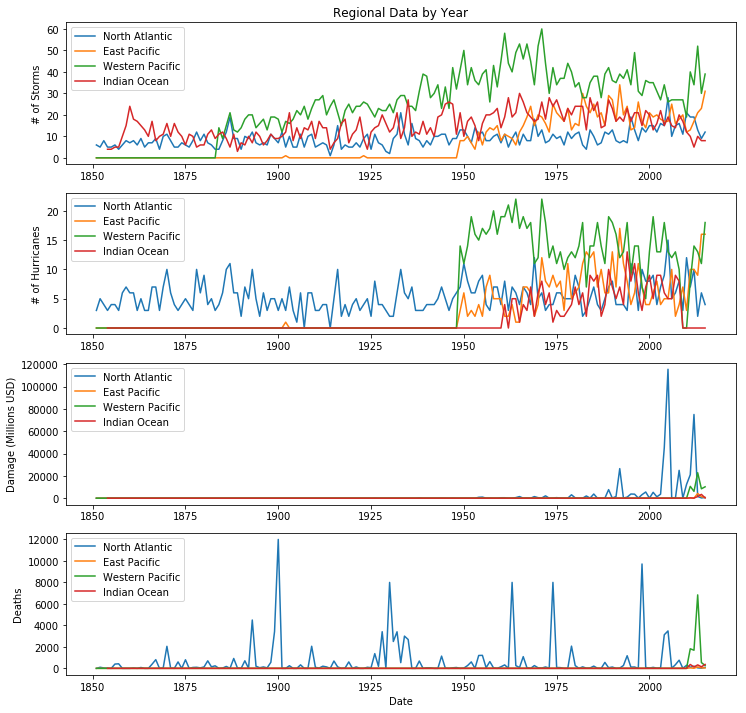

In [4]:
# - Simple plots
def plot_helper(data, ax, title=None, ylabel=None):
    """Helper function to plot data"""
    data.plot(ax=ax)    
    if title is not None:
        ax.set_title(title)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.legend()

storms = region_df.xs('Storms', axis=1, level='Statistic')
hurricanes = region_df.xs('Hurricanes', axis=1, level='Statistic')
damages = region_df.xs('Damage', axis=1, level='Statistic')
deaths = region_df.xs('Deaths', axis=1, level='Statistic')
    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(12, 12))
plot_helper(storms, ax1, ylabel='# of Storms')
plot_helper(hurricanes, ax2, ylabel='# of Hurricanes')
plot_helper(damages, ax3, ylabel='Damage (Millions USD)')
plot_helper(deaths, ax4, ylabel='Deaths')

ax1.set_title('Regional Data by Year')
ax4.set_xlabel('Date');

In [5]:
# - Region-Year Data Processing
def process_region_year_data_helper(year, k, v):
    """Helper function to process region-year data"""
    numeric_flds = ['Max Winds', 'Min Pressure', 'Deaths', 'Damage']
    if k == 'Storm':
        return v
    elif k == 'Dates':
        spl_dts = v.replace('-', ' ').split(' ')
        ret = list()
        for dt in spl_dts:
            t_dt = dt.strip()
            if t_dt == '' or t_dt.startswith('999'):
                continue
            
            sub_spl_dts = t_dt.split('/')
            sub_spl_dts[0] = np.mod(int(sub_spl_dts[0]), 13)
            if sub_spl_dts[0] == 0:
                sub_spl_dts[0] = 1
            
            str_dts = ["/{}".format(x) for x in sub_spl_dts]
            
            str_dt = str(year)+''.join(str_dts)
            try:
                t_dtime = datetime.strptime(str_dt, '%Y/%m/%d')
            except ValueError as verr:
                str_dt = "{}/{}/1".format(year, sub_spl_dts[0]+1)
                t_dtime = datetime.strptime(str_dt, '%Y/%m/%d') - timedelta(days=1)
                
            ret.append(t_dtime)
        
        ret_names = ['Start Date', 'End Date']
        ret_dict = dict()
        for i in range(len(ret)):
            ret_dict[ret_names[i]] = ret[i]
                
        return ret_dict
    
    elif k in numeric_flds:
        if v == '' or v == 'Unknown':
            return np.nan
        elif v == 'Minimal':
            return 0.
        elif v == 'Millions':
            return 1000000.
        else:
            strip_chars = [',', '>', '<', '+']
            t_v = v
            for x in strip_chars:
                t_v = t_v.replace(x, '')
            
            ret = float(t_v)
            if ret == 9999.:
                ret = np.nan
            return ret
       
    else:
        return v

def process_region_year_data(region, year, storm_id, storm_data):
    """Processes year-data to get storms"""
    unq_id = ''.join([x[0].upper() for x in region.split(' ')])
    unq_id += '{}{:02}'.format(year, storm_id)
    
    ret_data = dict()
    ret_data['Region'] = region
    for k, v in storm_data.items():
        try:
            t_ret_data = process_region_year_data_helper(year, k, v)
            if isinstance(t_ret_data, dict):
                ret_data = {**ret_data, **t_ret_data}
            else:
                ret_data[k] = t_ret_data
        except Exception as ex:
            print(k, v)
            raise ex
    
    return unq_id, ret_data

storm_year_data = dict()
for region, year_data in raw_data['region_year_data'].items():
    for yr, data in year_data.items():
        for t_storm_id, t_storm_data in data.items():
            t_id, t_data = process_region_year_data(region, yr, t_storm_id, t_storm_data)
            storm_year_data[t_id] = t_data

In [6]:
storm_year_df = None
for k, v in storm_year_data.items():
    t_df = pd.DataFrame(v, index=[k])
    
    if storm_year_df is None:
        storm_year_df = t_df
    else:
        storm_year_df = pd.concat([storm_year_df, t_df], axis=0, sort=False)

storm_year_df.index.name = 'StormID'
storm_year_df.sort_values('Start Date', axis=0, inplace=True)

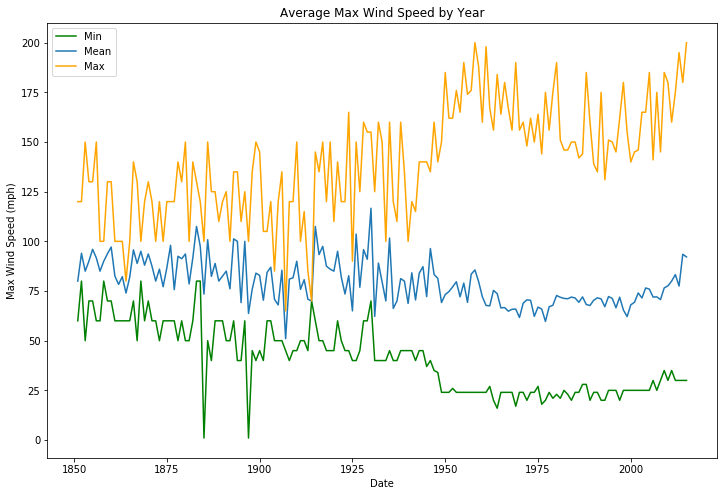

In [7]:
# - Max Winds over Time
nz_maxwind_filter = (storm_year_df.loc[:, 'Max Winds'] > 0) \
                    & ~np.isnan(storm_year_df.loc[:, 'Max Winds'])
max_winds = storm_year_df.where(nz_maxwind_filter).set_index('Start Date') \
                         .loc[:, 'Max Winds']

# - Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()

max_winds.groupby(max_winds.index.year, axis=0).min().plot(ax=ax, label='Min', 
                                                           color='green')
max_winds.groupby(max_winds.index.year, axis=0).mean().plot(ax=ax, label='Mean')
max_winds.groupby(max_winds.index.year, axis=0).max().plot(ax=ax, label='Max', 
                                                           color='orange')

ax.set_title('Average Max Wind Speed by Year')
ax.set_ylabel('Max Wind Speed (mph)')
ax.set_xlabel('Date')
ax.legend();

In [8]:
def process_single_track_point(data_dict):
    """Helper function to process single track data point"""
    key_dt = None
    key_tm = None
    vals = dict()
    
    for k, v in data_dict.items():
        if k == 'Date':
            b_is_numeric = False
            try:
                _ = int(v[0])
                key_dt = datetime.strptime(v, '%m/%d/%Y').date()
            except Exception:
                key_dt = datetime.strptime(v, '%b/%d/%Y').date()
        
        elif k == 'Time':
            if len(v.split(' ')[0]) > 2:
                key_tm = datetime.strptime(v, '%H%M %Z').time()
            else:
                key_tm = datetime.strptime(v, '%H %Z').time()
        
        elif k == 'Storm Type':
            vals[k] = v
        
        else:
            if v == 'Unknown':
                t_v = np.nan
            else:
                t_v = float(v)
            
            vals[k] = t_v
    
    return datetime.combine(key_dt, key_tm), vals


def process_storm_track_data_points(region, year, storm_id, track_data):
    """Helper function to process track data points"""
    storm_code = ''.join([x[0] for x in region.upper().split(' ')])
    storm_code += '{}{:02d}'.format(year, storm_id)
    
    ret = dict()
    for data_point in track_data:
        try:
            fmt_date, fmt_data = process_single_track_point(data_point)
        except Exception as ex:
            print(data_point)
            raise ex
        ret[fmt_date] = fmt_data
    
    return storm_code, ret


track_data = dict()
for region, region_data in raw_data['storm_data'].items():
    for year, storms in region_data.items():
        for storm_id, storm_track_data in storms.items():
            t_id, t_data = process_storm_track_data_points(region, year, storm_id, 
                                                           storm_track_data)
            track_data[t_id] = t_data